In [1]:
##Monitoring code:
 
# Optimized post-processing for Coherence Time and Frequency Monitoring (Series Temporal) - qubit frequency reference is min
 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
import numpy as np
 
# Path configuration and CSV files

DATASET_DIR = Path("/home/lauramartinez/my_envs/monitoring/datasets_QPU147")
DATASET_DIR.mkdir(parents=True, exist_ok=True)
 
# List of CSV files to read (INPUT)
csv_file_names = [
    #QPU147
    #Q0
    # "20251002_Q0_coherence_monitoring_log.csv",
    # "20251003_Q0_coherence_monitoring_log.csv",
    # "20251004_1_Q0_coherence_monitoring_log.csv",
    # "20251004_2_Q0_coherence_monitoring_log.csv",
    # "20251005_Q0_coherence_monitoring_log.csv",
    # "20251006_1_Q0_coherence_monitoring_log.csv",
    # "20251006_2_Q0_coherence_monitoring_log.csv",
    # "20251006_3_Q0_coherence_monitoring_log.csv",
    # "20251006_4_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",

    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv",
    "20251022_Q4_coherence_monitoring_log.csv" # Unica sesión que contiene qubit frequency
    #QPU149
    #Q1
    # "20251124_coherence_monitoring_log_q1.csv"
    #Q2
    # "20251121_coherence_monitoring_log_q2.csv",
    #Q3
    # "20251118_coherence_monitoring_log_q3.csv",
    # "20251123_coherence_monitoring_log_q3.csv"

]
 
csv_paths = [DATASET_DIR / name for name in csv_file_names]

print("Looking for CSV files in:", DATASET_DIR)
for f in csv_paths:
    print(f"{f.name}: exists? {f.exists()}")


qubit = "Q4" 
 
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")


# Frecuencia de referencia en GHz (introduce aquí la que quieras)
REFERENCE_FREQ_GHZ = 5.43911  # <- reemplaza con tu valor deseado

# Read and combine CSVs

dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        dfs.append(df)
        print(f"✅ File read: {f.name}")

    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")
 
if not dfs:
    raise ValueError("No valid data after filtering.")
 
data = pd.concat(dfs, ignore_index=True)
 
# Clean and process data

data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values("Timestamp").reset_index(drop=True)
 
# Gap detection

GAP_THRESHOLD_MINUTES = 15
data["TimeDiff"] = data["Timestamp"].diff().dt.total_seconds()
data["Gap"] = data["TimeDiff"] > (GAP_THRESHOLD_MINUTES * 60)
 
# Save combined dataset

output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
data.to_csv(output_csv_path, index=False)
print(f"\n✅ Combined data saved to {output_csv_path}")
 
# Plotting options

coherence_metrics = ["T1", "T2*", "T2E"]
frequency_metric = "Qubit Frequency" 
metrics_to_plot = coherence_metrics + [frequency_metric]
 
# Colores

colors = {"T1": "blue", "T2*": "orange", "T2E": "green", "Qubit Frequency": "red"}
unit_conversion = {"T1": 1e6, "T2*": 1e6, "T2E": 1e6, "Qubit Frequency": 1e-9}
y_labels = {"T1": "Coherence Times ($\\mu$s)", "Qubit Frequency": "Frequency (GHz)"}
 
# Filter out extreme values (optional)

MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None, "Qubit Frequency": None} 
data_filtered = data.copy()
datos_incoherentes = []
mask = pd.Series(True, index=data_filtered.index)

for t in metrics_to_plot:
    if MAX_VALUES[t] is not None:
        t_values = data_filtered[t] * unit_conversion[t]
        mask &= t_values <= MAX_VALUES[t]
 
datos_incoherentes.append(data_filtered[~mask])
data_filtered = data_filtered[mask]
print(f"✅ Rows kept after filtering: {len(data_filtered)}")
print(f"⚠️ Rows removed due to exceeding thresholds: {len(pd.concat(datos_incoherentes))}")
 
# Session-based plotting (continuous blocks without large gaps)

data_filtered = data_filtered.sort_values("Timestamp").reset_index(drop=True)
data_filtered['SessionID'] = data_filtered['Gap'].cumsum()
session_ids = data_filtered['SessionID'].unique()

for session in session_ids:
    df_session = data_filtered[data_filtered['SessionID'] == session].copy()
    # --- 1. Create figure with 3 subplots: T1/T2, Frequency, Stats Box ---

    fig, (ax_t1t2, ax_freq, ax_box) = plt.subplots(
        3, 1, figsize=(12, 10),
        gridspec_kw={'height_ratios': [4, 3, 1]},
        constrained_layout=True
    )

    # --- 2. Coherence Scatter plot (T1, T2*, T2E) ---

    stats_data = {} # Diccionario para guardar estadísticas de la sesión
    for t in coherence_metrics:
        values_us = df_session[t] * unit_conversion[t]
        mean_val = values_us.mean()
        std_val = values_us.std()

        # 1. Almacenar estadísticas
        stats_data[t] = {
            'mean': mean_val, 
            'std': std_val,
            'min': values_us.min(), 
            'max': values_us.max()
        }
 
        # 2. Plotear Puntos
        label_text = f"{t}"
        ax_t1t2.scatter(
            df_session["Timestamp"], 
            values_us, 
            s=25, 
            color=colors[t], 
            label=label_text
        )

        # 3. Añadir Banda de Desviación Estándar (STD de la sesión)
        ax_t1t2.axhspan(
            mean_val - std_val, mean_val + std_val,
            color=colors[t], alpha=0.15, 
            label=None # NO añadir esta banda a la leyenda
        )

    ax_t1t2.set_title(f"Coherence & Frequency Monitoring - Session {session} - Qubit {qubit}")
    ax_t1t2.set_ylabel(y_labels["T1"])
    ax_t1t2.grid(True, alpha=0.3)
    ax_t1t2.legend(fontsize=9, loc="upper right")

    # Ocultar etiquetas X del plot superior

    plt.setp(ax_t1t2.get_xticklabels(), visible=False)

# --- 3. Frequency Scatter plot (f01) ---
    values_ghz = (df_session[frequency_metric] * unit_conversion[frequency_metric])

    # Calcular estadísticas de frecuencia
    mean_freq = values_ghz.mean()
    std_freq = values_ghz.std()
    min_freq = values_ghz.min()

    # Almacenar estadísticas de frecuencia
    stats_data[frequency_metric] = {
        'mean': mean_freq, 
        'std': std_freq,
        'min': min_freq, 
        'max': values_ghz.max()
    }
    
    # Calculate the plotted data (Relative to min, scaled to kHz)
    values_khz = (values_ghz - min_freq) * 1e6
    
    # Scatter plot de frecuencia
    ax_freq.scatter(
        df_session["Timestamp"], 
        values_khz, # Data plotted on the relative kHz scale
        s=25, 
        color=colors[frequency_metric], 
        label=frequency_metric
    )
    
    # Banda de desviación estándar
    mean_plot_val = (mean_freq - min_freq) * 1e6
    std_plot_val = std_freq * 1e6
    
    ax_freq.axhspan(
        mean_plot_val - std_plot_val, 
        mean_plot_val + std_plot_val,
        color=colors[frequency_metric], alpha=0.15,
        label=None 
    )


    # Configurar el eje X (es el mismo para los dos scatter plots)
    ax_freq.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    ax_freq.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))

    # Rotar las etiquetas en el plot de frecuencia (el más bajo de los ejes X)
    plt.setp(ax_freq.get_xticklabels(), rotation=45, ha='right')
    ax_freq.set_xlabel("Date & Time")
    
    # NOTE: The Y-label will now refer to the RELATIVE kHz scale. 
    # You might want to update the label text if it currently says "Frequency [GHz]".
    ax_freq.set_ylabel("dF [kHz]") 
    
    ax_freq.grid(True, alpha=0.3)
    ax_freq.legend(fontsize=9, loc="upper right")

    # --- 4. Statistics box ---
    stats_text = ""
    for t in metrics_to_plot:
        data = stats_data[t]
        unit = "$\\mu$s" if t in coherence_metrics else "GHz"
        stats_text += (
            f"{t} $\\rightarrow$ mean={data['mean']:.3f} {unit}, "
            f"std={data['std']:.3f} {unit}, "
            f"min={data['min']:.3f} {unit}, max={data['max']:.3f} {unit}\n"
        )

    ax_box.axis("off")
    ax_box.text(
        0.5, 0.5, stats_text.strip(),
        ha='center', va='center',
        fontsize=10,
        family='monospace',
        bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.6')
    )
    plt.show()

Looking for CSV files in: /home/lauramartinez/my_envs/monitoring/datasets_QPU147
20251022_Q4_coherence_monitoring_log.csv: exists? False
⚠️ Error reading 20251022_Q4_coherence_monitoring_log.csv: [Errno 2] No such file or directory: '/home/lauramartinez/my_envs/monitoring/datasets_QPU147/20251022_Q4_coherence_monitoring_log.csv'


ValueError: No valid data after filtering.

In [1]:
## Monitoring code: Optimized post-processing for Coherence Time and Frequency Monitoring (Series Temporal)
# Cada CSV produce un plot individual con su propio título
# Qubit frequency reference es la media de todos los datos combinados

# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
import numpy as np

# Path configuration and CSV files
DATASET_DIR = Path("/home/lauramartinez/my_envs/monitoring/datasets_QPU149") # Cambia según QPU
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSV files to read
csv_file_names = [
    #QPU147
    #Q0
    # "20251002_Q0_coherence_monitoring_log.csv",
    # "20251003_Q0_coherence_monitoring_log.csv",
    # "20251004_1_Q0_coherence_monitoring_log.csv",
    # "20251004_2_Q0_coherence_monitoring_log.csv",
    # "20251005_Q0_coherence_monitoring_log.csv",
    # "20251006_1_Q0_coherence_monitoring_log.csv",
    # "20251006_2_Q0_coherence_monitoring_log.csv",
    # "20251006_3_Q0_coherence_monitoring_log.csv",
    # "20251006_4_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",

    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv",
    # "20251022_Q4_coherence_monitoring_log.csv" # Unica sesión que contiene qubit frequency

    #QPU149
    #Q1
    # "20251124_coherence_monitoring_log_q1.csv"
    #Q2
    # "20251121_coherence_monitoring_log_q2.csv",
    #Q3
    "20251118_coherence_monitoring_log_q3.csv",
    "20251123_coherence_monitoring_log_q3.csv"
    "20251125_coherence_monitoring_log_q3.csv"

]

csv_paths = [DATASET_DIR / name for name in csv_file_names]
print("Looking for CSV files in:", DATASET_DIR)
for f in csv_paths:
    print(f"{f.name}: exists? {f.exists()}")

qubit = "Q3"

if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")

# Read and combine CSVs  - Lectura y filtrado de datos
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)] # Filtrar filas inválidas
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

data = pd.concat(dfs, ignore_index=True)

# Clean and process data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values("Timestamp").reset_index(drop=True)

# Gap detection
GAP_THRESHOLD_MINUTES = 60
data["TimeDiff"] = data["Timestamp"].diff().dt.total_seconds()
data["Gap"] = data["TimeDiff"] > (GAP_THRESHOLD_MINUTES * 60)

# Save combined dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
data.to_csv(output_csv_path, index=False)
print(f"\n✅ Combined data saved to {output_csv_path}")

# Plotting options
coherence_metrics = ["T1", "T2*", "T2E"]
frequency_metric = "Qubit Frequency"
metrics_to_plot = coherence_metrics + [frequency_metric]

# Colores
colors = {"T1": "blue", "T2*": "orange", "T2E": "green", "Qubit Frequency": "red"}

# Conversion units
unit_conversion = {"T1": 1e6, "T2*": 1e6, "T2E": 1e6, "Qubit Frequency": 1e-9}
y_labels = {"T1": "Coherence Times ($\\mu$s)", "Qubit Frequency": "Frequency (GHz)"}

# Filter out extreme values (optional)
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None, "Qubit Frequency": None}
data_filtered = data.copy()
datos_incoherentes = []
mask = pd.Series(True, index=data_filtered.index)
for t in metrics_to_plot:
    if MAX_VALUES[t] is not None:
        t_values = data_filtered[t] * unit_conversion[t]
        mask &= t_values <= MAX_VALUES[t]
        datos_incoherentes.append(data_filtered[~mask])
data_filtered = data_filtered[mask]
print(f"✅ Rows kept after filtering: {len(data_filtered)}")
print(f"⚠️ Rows removed due to exceeding thresholds: {len(pd.concat(datos_incoherentes))}")

# Session-based plotting
data_filtered = data_filtered.sort_values("Timestamp").reset_index(drop=True)
data_filtered['SessionID'] = data_filtered['Gap'].cumsum()
session_ids = data_filtered['SessionID'].unique()

# Global frequency reference
all_values_ghz = data_filtered[frequency_metric] * unit_conversion[frequency_metric]
GLOBAL_MEAN_FREQ = all_values_ghz.mean() # Media aritmética como referencia global de todas las sesiones
print(f"Global reference frequency (all sessions mean): {GLOBAL_MEAN_FREQ:.6f} GHz")

for session in session_ids:
    df_session = data_filtered[data_filtered['SessionID'] == session].copy()

    # --- 1. Create figure ---
    fig, (ax_t1t2, ax_freq, ax_box) = plt.subplots(
        3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [4, 3, 1]}, constrained_layout=True
    )

    # --- 2a. Coherence metrics ---
    stats_data = {}
    for t in coherence_metrics:
        values_us = df_session[t] * unit_conversion[t]
        mean_val = values_us.mean()
        std_val = values_us.std()
        stats_data[t] = {'mean': mean_val, 'std': std_val, 'min': values_us.min(), 'max': values_us.max()}

        ax_t1t2.scatter(df_session["Timestamp"], values_us, s=25, color=colors[t], label=t)
        ax_t1t2.axhspan(mean_val - std_val, mean_val + std_val, color=colors[t], alpha=0.15)

    ax_t1t2.set_title(f"Coherence & Frequency Monitoring - Session {session} - Qubit {qubit}")
    ax_t1t2.set_ylabel(y_labels["T1"])
    ax_t1t2.grid(True, alpha=0.3)
    ax_t1t2.legend(fontsize=9, loc="upper right")
    plt.setp(ax_t1t2.get_xticklabels(), visible=False)

    # --- 2b. Frequency metrics ---
    values_ghz = df_session[frequency_metric] * unit_conversion[frequency_metric]
    values_khz = (values_ghz - GLOBAL_MEAN_FREQ) * 1e6

    mean_khz = values_khz.mean()
    std_khz = values_khz.std()

    stats_data[frequency_metric] = {
        'mean': values_ghz.mean(),
        'std': values_ghz.std(),
        'min': values_ghz.min(),
        'max': values_ghz.max()
    }

    ax_freq.scatter(df_session["Timestamp"], values_khz, s=25, color=colors[frequency_metric],
                    label=f"{frequency_metric} (session {session})")
    ax_freq.axhspan(mean_khz - std_khz, mean_khz + std_khz,
                    color=colors[frequency_metric], alpha=0.15)
    ax_freq.scatter([], [], color='black', label=f"Global Reference: {GLOBAL_MEAN_FREQ:.6f} GHz")

    ax_freq.xaxis.set_major_locator(mdates.MinuteLocator(interval=15)) # Modificar si las horas se plotean muy juntas
    ax_freq.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax_freq.get_xticklabels(), rotation=45, ha='right')
    ax_freq.set_xlabel("Date & Time")
    ax_freq.set_ylabel("ΔF [kHz]")
    ax_freq.grid(True, alpha=0.3)
    ax_freq.legend(fontsize=9, loc="upper right")

    # --- 3. Statistics box ---
    stats_text = ""
    for t in metrics_to_plot:
        data_stat = stats_data[t]
        if t in coherence_metrics:
            unit = "$\\mu$s"
            stats_text += (f"{t} $\\rightarrow$ mean={data_stat['mean']:.3f} {unit}, "
                           f"std={data_stat['std']:.3f} {unit}, "
                           f"min={data_stat['min']:.3f} {unit}, max={data_stat['max']:.3f} {unit}\n")
        else:
            stats_text += (f"{t} $\\rightarrow$ mean={data_stat['mean']:.6f} GHz, "
                           f"std={data_stat['std']*1e6:.3f} kHz, "
                           f"min={data_stat['min']:.6f} GHz, max={data_stat['max']:.6f} GHz\n")

    ax_box.axis("off")
    ax_box.text(0.5, 0.5, stats_text.strip(),
                ha='center', va='center', fontsize=10, family='monospace',
                bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.6'))

    plt.show()


Looking for CSV files in: /home/lauramartinez/my_envs/monitoring/datasets_QPU149
20251118_coherence_monitoring_log_q3.csv: exists? False
20251123_coherence_monitoring_log_q3.csv20251125_coherence_monitoring_log_q3.csv: exists? False
⚠️ Error reading 20251118_coherence_monitoring_log_q3.csv: [Errno 2] No such file or directory: '/home/lauramartinez/my_envs/monitoring/datasets_QPU149/20251118_coherence_monitoring_log_q3.csv'
⚠️ Error reading 20251123_coherence_monitoring_log_q3.csv20251125_coherence_monitoring_log_q3.csv: [Errno 2] No such file or directory: '/home/lauramartinez/my_envs/monitoring/datasets_QPU149/20251123_coherence_monitoring_log_q3.csv20251125_coherence_monitoring_log_q3.csv'


ValueError: No valid data after filtering.

Looking for CSV files in: /home/lauramartinez/my_envs/monitoring/datasets_QPU149
20251118_coherence_monitoring_log_q3.csv: exists? True
20251123_coherence_monitoring_log_q3.csv: exists? True
20251125_coherence_monitoring_log_q3.csv: exists? True
✅ File read: 20251118_coherence_monitoring_log_q3.csv
✅ File read: 20251123_coherence_monitoring_log_q3.csv
✅ File read: 20251125_coherence_monitoring_log_q3.csv

✅ CSV: 20251118_coherence_monitoring_log_q3.csv
Rows kept after filtering: 998
Rows removed due to thresholds: 0


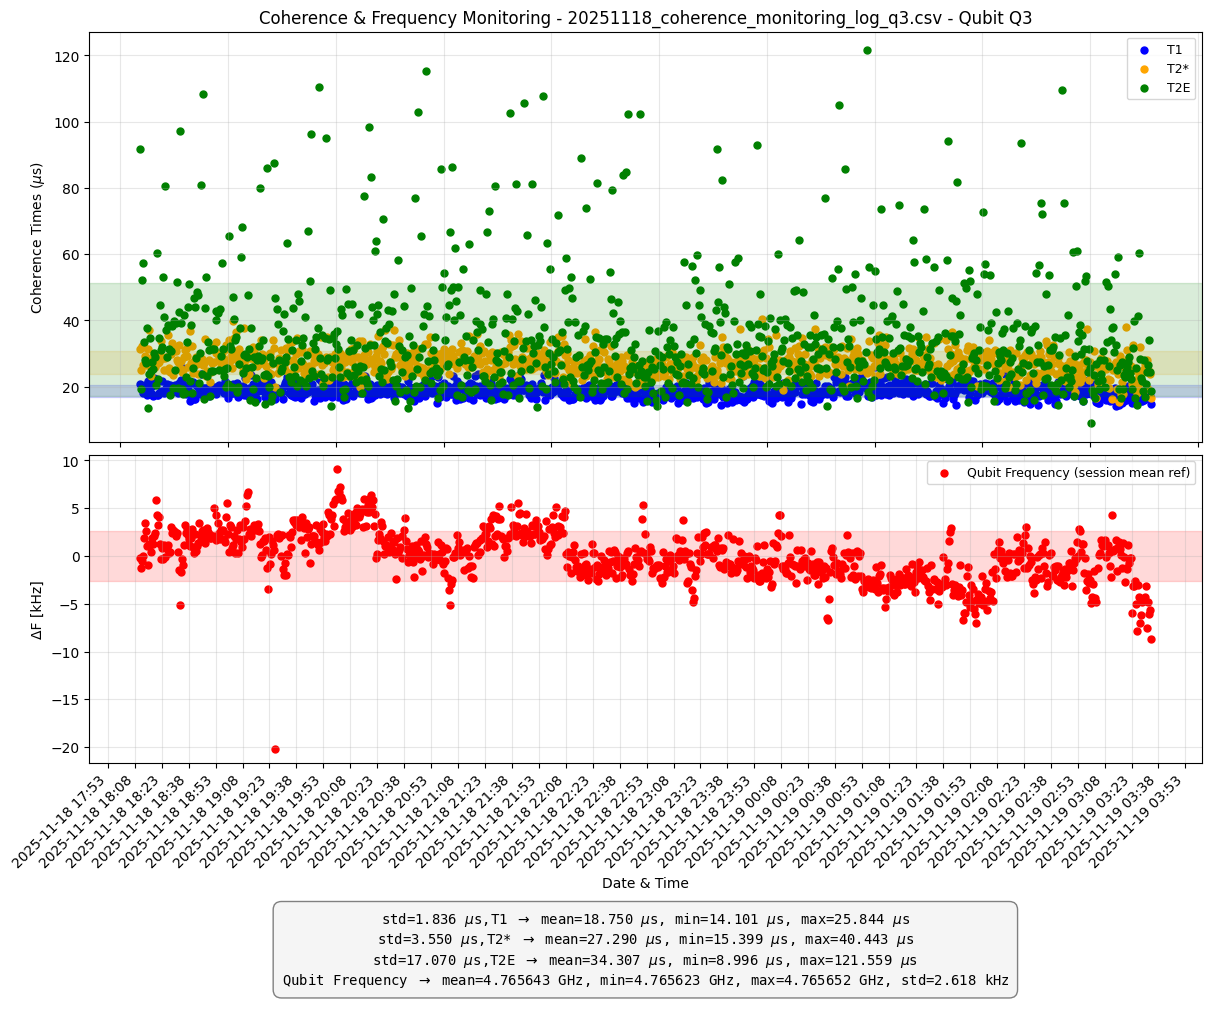


✅ CSV: 20251123_coherence_monitoring_log_q3.csv
Rows kept after filtering: 493
Rows removed due to thresholds: 0


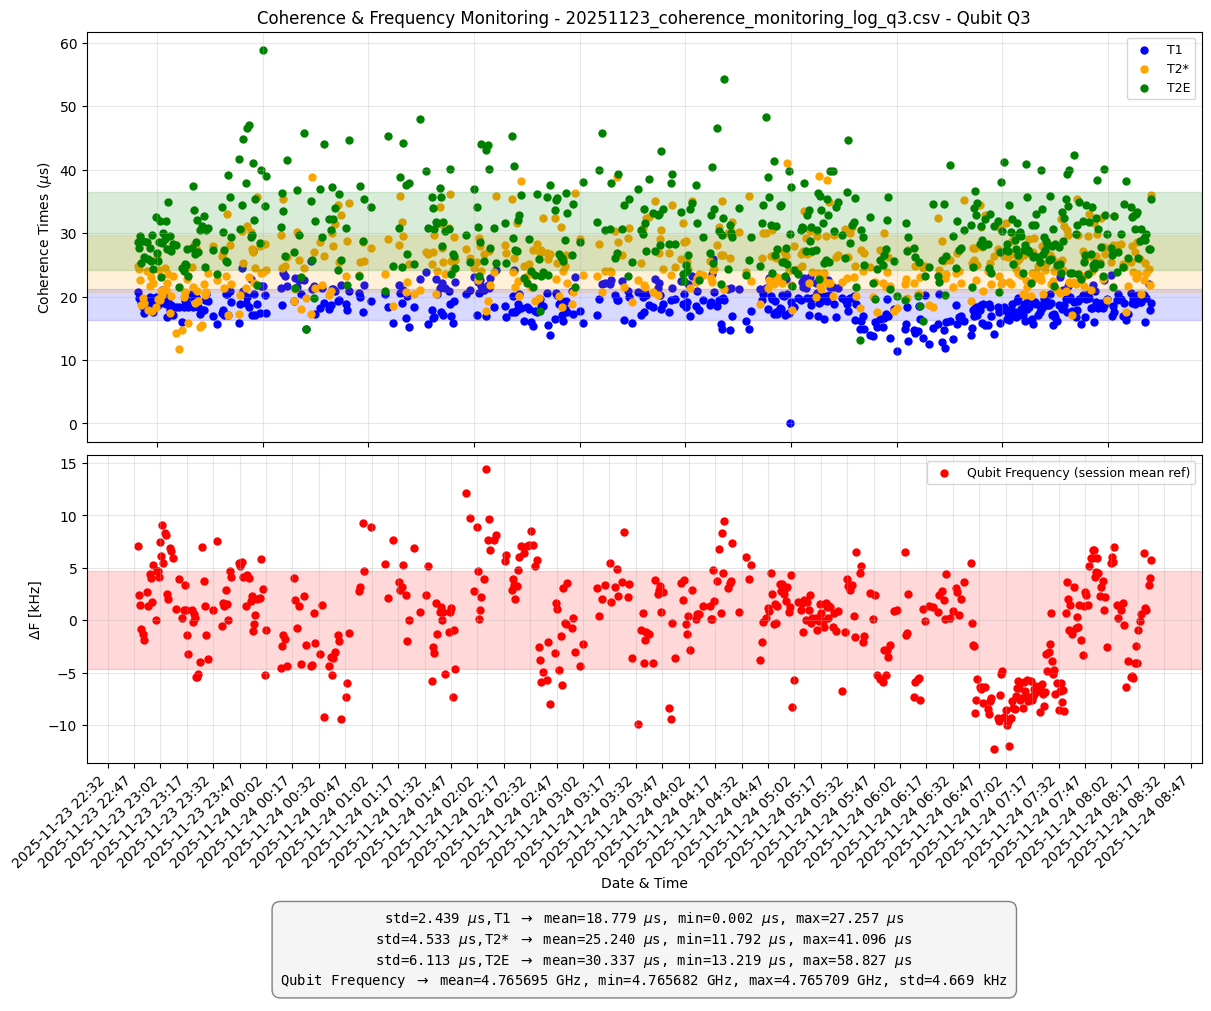


✅ CSV: 20251125_coherence_monitoring_log_q3.csv
Rows kept after filtering: 674
Rows removed due to thresholds: 0


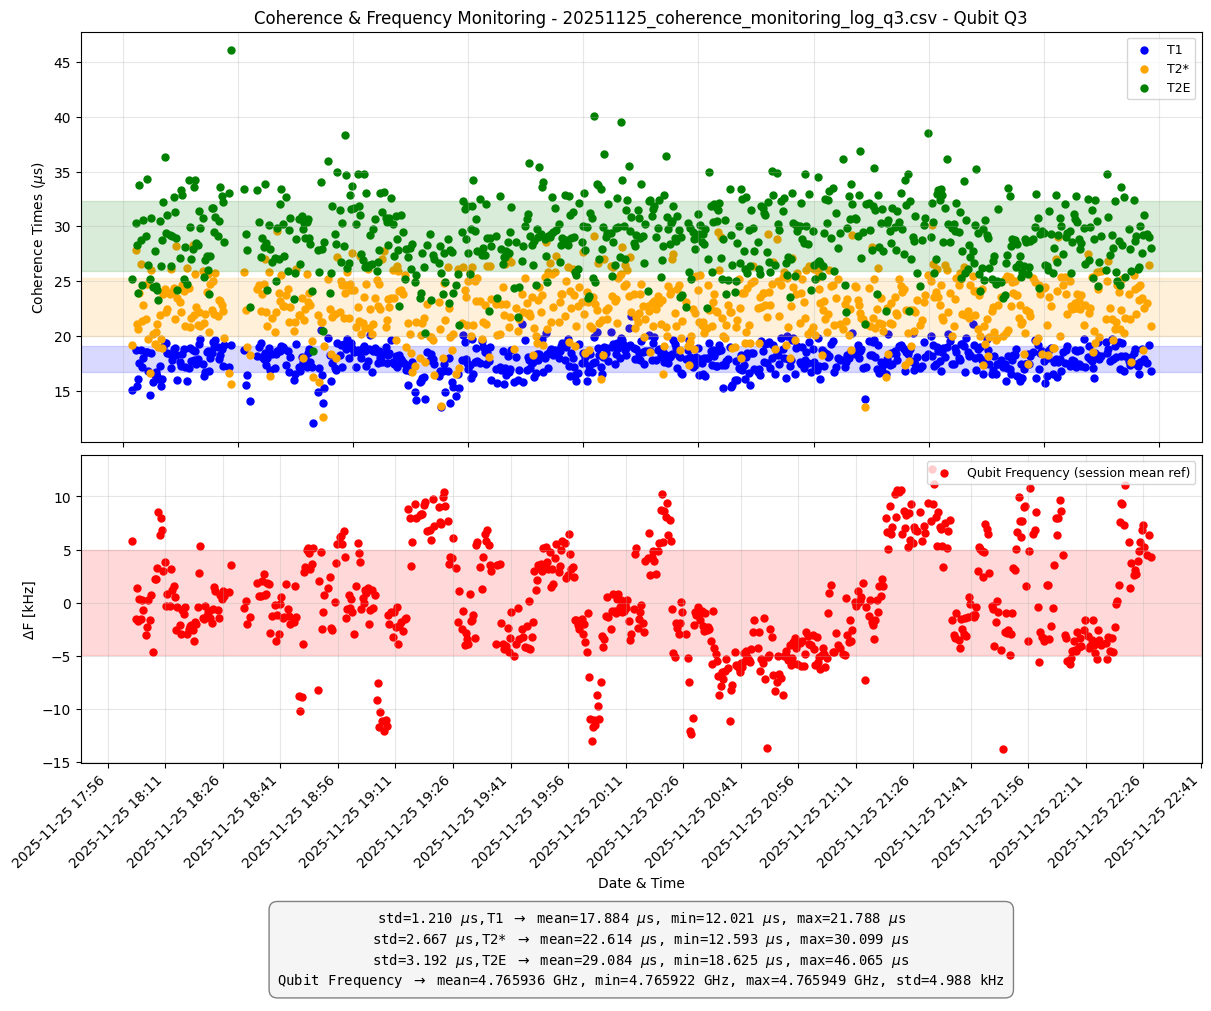

In [8]:
## Monitoring code: Optimized post-processing for Coherence Time and Frequency Monitoring (Series Temporal)
# Cada CSV produce un plot individual con su propio título
# Qubit frequency reference es la media de todos los datos combinados
# PENDIENTE DE REVISIÓN. HE PEDIDO A CHAT GPT QUE EL CODIGO ME PERMITIESE HACER PLOT POR SESION Y TITULARLOS SESION 0, SESION 1, ...
# Estaria bien anadir tambien los calculos que hacemos posteriormente a mano para rellenar la tabla en el reporte.

## Monitoring code: Optimized post-processing for Coherence Time and Frequency Monitoring (Series Temporal)
# Cada CSV produce un plot individual con su propio título
# Qubit frequency reference se calcula por CSV (media de esa sesión)

# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
import numpy as np

# Path configuration and CSV files
DATASET_DIR = Path("/home/lauramartinez/my_envs/monitoring/datasets_QPU149")  # Cambia según QPU
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSV files to read
csv_file_names = [
    "20251118_coherence_monitoring_log_q3.csv",
    "20251123_coherence_monitoring_log_q3.csv",
    "20251125_coherence_monitoring_log_q3.csv"
]

csv_paths = [DATASET_DIR / name for name in csv_file_names]
print("Looking for CSV files in:", DATASET_DIR)
for f in csv_paths:
    print(f"{f.name}: exists? {f.exists()}")

qubit = "Q3"

if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")

# Read CSVs and store dataframes
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]  # Filtrar filas inválidas (primer filtro)
        dfs.append(df) # Los dataframes se almacenan en una lista dfs una vez depurados
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

# Opciones de plotting - Crear más columnas con más datos si se desea
coherence_metrics = ["T1", "T2*", "T2E"] # Nombre de las columnas asociadas a las métricas de coherencia
frequency_metric = "Qubit Frequency" # Nombre de la columna asociada a la métrica de frecuencia
metrics_to_plot = coherence_metrics + [frequency_metric] 
colors = {"T1": "blue", "T2*": "orange", "T2E": "green", "Qubit Frequency": "red"}
unit_conversion = {"T1": 1e6, "T2*": 1e6, "T2E": 1e6, "Qubit Frequency": 1e-9}
y_labels = {"T1": "Coherence Times ($\\mu$s)", "Qubit Frequency": "Frequency (GHz)"}
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None, "Qubit Frequency": None} # MODIFICAR si se quieren filtrar valores extremos

# Loop sobre cada CSV y generar plot individual
# Resultado: dfs es una LISTA con 3 dataframes separados
# dfs[0] = datos del CSV 0 (20251118...)
# dfs[1] = datos del CSV 1 (20251123...)
# dfs[2] = datos del CSV 2 (20251125...)

for i, f in enumerate(csv_paths): # Iterar sobre cada CSV / i:= indice del CSV actual, f:= path del CSV actual
    df = dfs[i].copy() # Obtener el dataframe correspondiente al CSV actual que se guardó previamente en la lista dfs
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values("Timestamp").reset_index(drop=True) 

    # Filtrado de valores extremos. Solo se aplica si se ha establecido un umbral máximo para alguna métrica
    datos_incoherentes = []
    mask = pd.Series(True, index=df.index)
    for t in metrics_to_plot:
        if MAX_VALUES[t] is not None:
            t_values = df[t] * unit_conversion[t] # Conversión a unidades adecuadas
            mask &= (t_values <= MAX_VALUES[t]) # Pasamos a False las filas que exceden el umbral

    df_filtered = df[mask] # Selecciona las filas donde mask es True
    datos_incoherentes = df[~mask] # Almacenar datos incoherentes en la lista (~ es el operador NOT)
    

    print(f"\n✅ CSV: {f.name}")
    print(f"Rows kept after filtering: {len(df_filtered)}")
    print(f"Rows removed due to thresholds: {len(datos_incoherentes)}")

    # --- 1. Create figure ---
    fig, (ax_t1t2, ax_freq, ax_box) = plt.subplots(
        3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [4, 3, 1]}, constrained_layout=True
    )

    # --- 2a. Coherence metrics ---
    # Trabajamos sobre los datos (absolutos)
    # Por qué los tiempos de coherencia se reportan en valores absolutos? Representan tiempos de vida.
    # La pregunta importante es cual es su valor actual y si ha cambiado respecto a valores previos (absolutos).
    stats_data = {}
    for t in coherence_metrics:
        values_us = df_filtered[t] * unit_conversion[t]
        mean_val = values_us.mean()
        std_val = values_us.std()
        stats_data[t] = {'mean': mean_val, 'std': std_val, 'min': values_us.min(), 'max': values_us.max()}

        ax_t1t2.scatter(df_filtered["Timestamp"], values_us, s=25, color=colors[t], label=t)
        ax_t1t2.axhspan(mean_val - std_val, mean_val + std_val, color=colors[t], alpha=0.15) # Banda - Visualiza la dispersión mostrando donde se concentran la mayoría de medidas
                                                                                             # (puntos) - Esto ayuda a ver si un punto es una anomalía o está dentro de lo normal

    ax_t1t2.set_title(f"Coherence & Frequency Monitoring - {f.name} - Qubit {qubit}")
    ax_t1t2.set_ylabel(y_labels["T1"])
    ax_t1t2.grid(True, alpha=0.3)
    ax_t1t2.legend(fontsize=9, loc="upper right")
    plt.setp(ax_t1t2.get_xticklabels(), visible=False)

    # --- 2b. Frequency metrics (referencia por sesión) ---
    # Datos absolutos en GHz
    values_ghz = df_filtered[frequency_metric] * unit_conversion[frequency_metric] # Conversión de las frecuencias a GHz
    
    # Datos relativos en kHz (referencia - media de la sesión)
    session_mean_freq_ghz = values_ghz.mean()  # OBS - referencia de esta sesión - Calculo de la frecuencia media de la sesión actual
    values_khz = (values_ghz - session_mean_freq_ghz) * 1e6 # Diferencia de frecuencia - Conversión de GHz a kHz
    
    
    stats_data[frequency_metric] = {
    # Datos absolutos en GHz
    'mean_ghz': values_ghz.mean(),
    'std_ghz': values_ghz.std(),
    'min_ghz': values_ghz.min(),
    'max_ghz': values_ghz.max(),
    # Datos relativos en kHz (referencia - media de la sesión)
    'mean_khz':  values_khz.mean(),
    'std_khz': values_khz.std(),
    'min_khz': values_khz.min(),
    'max_khz': values_khz.max()
    }
    # OBS: Para acceder a estos valores hacerlo directamente a través de las claves del diccionario stats_data

    
    # Configuración del plot de frecuencia
    ax_freq.scatter(df_filtered["Timestamp"], values_khz, s=25, color=colors[frequency_metric],
                    label=f"{frequency_metric} (session mean ref)")
    ax_freq.axhspan(stats_data[frequency_metric]['mean_khz'] - stats_data[frequency_metric]['std_khz'], stats_data[frequency_metric]['mean_khz'] + stats_data[frequency_metric]['std_khz'],     # Banda horizontal
                    color=colors[frequency_metric], alpha=0.15)

    ax_freq.xaxis.set_major_locator(mdates.MinuteLocator(interval=15)) # Modificar si las horas se plotean muy juntas
    ax_freq.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax_freq.get_xticklabels(), rotation=45, ha='right')
    ax_freq.set_xlabel("Date & Time")
    ax_freq.set_ylabel("ΔF [kHz]")
    ax_freq.grid(True, alpha=0.3)
    ax_freq.legend(fontsize=9, loc="upper right")

    # --- 3. Statistics box ---
    stats_text = ""
    for t in metrics_to_plot:
        data_stat = stats_data[t]
        if t in coherence_metrics:
            unit = "$\\mu$s"
            stats_text += (f"std={data_stat['std']:.3f} {unit},"
                           f"{t} $\\rightarrow$ mean={data_stat['mean']:.3f} {unit}, "
                           f"min={data_stat['min']:.3f} {unit}, max={data_stat['max']:.3f} {unit}\n")
        else:
            stats_text += (f"{t} $\\rightarrow$ mean={data_stat['mean_ghz']:.6f} GHz, "
                           f"min={data_stat['min_ghz']:.6f} GHz, max={data_stat['max_ghz']:.6f} GHz, "
                           f"std={data_stat['std_khz']:.3f} kHz\n")

    ax_box.axis("off")
    ax_box.text(0.5, 0.5, stats_text.strip(),
                ha='center', va='center', fontsize=10, family='monospace',
                bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.6'))

    plt.show()